In [24]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from PIL import Image
from tensorflow import keras
from glob import glob
import pandas as pd
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

To. 이지용 박사님,

이번에 보내주신 데이터에서 1000Hz의 Rp 값을 이용하였는데 지난번 보내주신 데이터들에 비해 impedance 수치가 높습니다. 하단에 있는 예측 테이블을 보시면 지난번 결과들에 비해 RMSE 값이 많이 높아진 것을 확인할 수 있습니다. 따라서 현재 제 생각으로는 해당 데이터를 예전 데이터와 합치는 것은 좋지 않을 것 같다는 판단입니다. 

Data Pre-processing - 보내주신 이미지를 (2560 x 1024) 사이즈의 이미지로 바꾸고 해당 엑셀파일에서 Rp값을 추출하여 저장하였습니다
CNN Training - 지난번 (256 x 1024)학습 방식과 동일하게 학습 
Results - 결과의 오차 단위가 지난 데이터와 비교하여 ~10배 차이납니다

# Data Pre-processing

In [46]:
#각 엑셀 파일에서 Rp, Rs 값 추출

file_names_list = []
imp_list = []
dir = "data_files/0713/excel_files"

for file in os.listdir(dir):
    file_name = dir + "/" + file
    f = open(file_name,'r', encoding='UTF8')
    rdr = list(csv.reader(f))
    Rp = round(float(rdr[120][8]), 3)
    #Rs = round(float(rdr[120][10]), 3)
    file_names_list.append(file.split("_")[1].replace(" ", "").replace(",", "").replace(".", ""))
    imp_list.append(Rp)
    
    print("file : ", file, "    Rp : ", Rp)
    
    f.close()


file :  Generic C-f [(1) _30, 1, no.6_; 7_3_2023 1_46_05 PM].csv     Rp :  26156.236
file :  Generic C-f [(1) _30, 3, no.7_; 7_3_2023 1_50_42 PM].csv     Rp :  50311.175
file :  Generic C-f [(1) _30, 5, no.1_; 7_3_2023 1_52_00 PM].csv     Rp :  209258.868
file :  Generic C-f [(1) _30, 5, no.2_; 7_3_2023 1_52_26 PM].csv     Rp :  193383.2
file :  Generic C-f [(1) _30, 5, no.4_; 7_3_2023 1_53_19 PM].csv     Rp :  276156.89
file :  Generic C-f [(1) _30, 5, no.5_; 7_3_2023 1_53_47 PM].csv     Rp :  245244.104
file :  Generic C-f [(1) _30, 5, no.7_; 7_3_2023 1_54_59 PM].csv     Rp :  199225.015
file :  Generic C-f [(1) _30, 7, no.1_; 7_3_2023 1_55_40 PM].csv     Rp :  272324.48
file :  Generic C-f [(1) _40, 1, no.5_; 7_3_2023 1_26_50 PM].csv     Rp :  16889.381
file :  Generic C-f [(1) _40, 5, no.2_; 7_3_2023 1_33_31 PM].csv     Rp :  70025.069
file :  Generic C-f [(10) _40, 3, no.5_; 7_3_2023 1_30_34 PM].csv     Rp :  44289.137
file :  Generic C-f [(10) _70, 3, no.5_; 7_3_2023 12_16_08 PM]

In [ ]:
# save cropped images with impedance values on their file names

In [28]:
ground_dir = "data_files/0713/"
image_dir = ground_dir + "images"
make_dir = ground_dir + "processed_images_Rp"
os.makedirs(make_dir)

count = 0

for file in os.listdir(image_dir):
    
    original_image_name = file[:-4].replace(" ", "").replace(",", "").replace(".", "")
    
    try:
        imp_index = file_names_list.index(original_image_name)
    except ValueError:
        print("cannot find excel file for : " + file)
        continue
     
    new_image_name = imp_list[imp_index]
    image = load_img(image_dir + "/" + file)
    cropped_image = image.crop((0,448,2560,1472))
    cropped_image.save(make_dir + "/" + str(new_image_name) + ".jpg")
    
    count += 1
    
print("saved " + str(count) + " images")

cannot find excel file for : 30, 3, no.1.jpg
cannot find excel file for : 30, 3, no.2.jpg
cannot find excel file for : 40, 3, no.3.jpg
cannot find excel file for : 40, 3, no.7.jpg
cannot find excel file for : 40, 5, no.3.jpg
cannot find excel file for : 40, 5, no.7.jpg
cannot find excel file for : 40, 7, no.1.jpg
cannot find excel file for : 40, 7, no.2.jpg
cannot find excel file for : 40, 7, no.4.jpg
cannot find excel file for : 40, 7, no.6.jpg
cannot find excel file for : 40, 7, no.7.jpg
cannot find excel file for : 40, 9, no.2.jpg
cannot find excel file for : 50, 5, no.1.jpg
cannot find excel file for : 50, 7, no.1.jpg
cannot find excel file for : 50, 7, no.6.jpg
cannot find excel file for : 60, 5, no.7.jpg
cannot find excel file for : 60, 7, no.7.jpg
cannot find excel file for : 60, 9, no.7.jpg
cannot find excel file for : 70, 1, no.1.jpg
cannot find excel file for : 70, 1, no.2.jpg
cannot find excel file for : 70, 1, no.3.jpg
cannot find excel file for : 70, 1, no.4.jpg
cannot fin

# CNN Training

In [29]:
# 학습용 이미지 쪼개기
# 저장된 이미지는 (1024*2560)

image_width = 256
image_height = 1024
rows = 1
columns = 10

X = []
Y = []

for file_name in os.listdir(make_dir):
    if file_name != '.DS_Store':
        image = Image.open(make_dir+"/"+file_name).convert("L")
        for j in range(rows):

            for i in range(columns):
                cropped = image.crop((i*image_width,j*image_height,(i+1)*image_width,(j+1)*image_height))
                cropped = np.array(cropped)
                X.append(cropped)
                Y.append(int(float(file_name[:-4])))

In [30]:
X = np.array(X)/255.0
Y = np.array(Y)
print(X.shape, Y.shape)

(1330, 1024, 256) (1330,)


In [31]:
standard_scaler_y = StandardScaler()
reshape_y = Y.reshape(-1,1)
reshape_y = standard_scaler_y.fit_transform(reshape_y)

In [32]:
test_size = 0.2
shuffle = True
random_state = 42

train_x, test_x, train_y, test_y = train_test_split(X, reshape_y, test_size=test_size, shuffle=shuffle, random_state=random_state)

In [33]:
# callback
patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [34]:
train_x_cnn = train_x[..., np.newaxis]
test_x_cnn = test_x[..., np.newaxis]

In [35]:
train_x_cnn.shape

(1064, 1024, 256, 1)

In [36]:
train_y.shape

(1064, 1)

In [37]:

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[1024, 256, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(32, activation='relu'))

# output layer
cnn_model.add(keras.layers.Dense(1))

# model complie
cnn_model.compile(optimizer='adam',loss='mse')

In [38]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1024, 256, 32)     1600      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 512, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 128, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 128, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 64, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 64, 128)     

In [39]:
path_directory = make_dir + ".h5"
istrue = os.path.exists(path_directory)

if not istrue:
    history = cnn_model.fit(train_x_cnn, train_y, callbacks=[early_stopping_cb],
                            epochs=100, validation_split=0.2)
    cnn_model.save(path_directory)
    print("model is saved")
else:
    cnn_model = keras.models.load_model(path_directory)
    print("model is loaded")

Epoch 1/100
27/27 [==============================] - 6s 201ms/step - loss: 5.1680 - val_loss: 0.7669
Epoch 2/100
27/27 [==============================] - 5s 189ms/step - loss: 0.9877 - val_loss: 0.7512
Epoch 3/100
27/27 [==============================] - 5s 188ms/step - loss: 0.9335 - val_loss: 0.7583
Epoch 4/100
27/27 [==============================] - 5s 189ms/step - loss: 0.9235 - val_loss: 0.6509
Epoch 5/100
27/27 [==============================] - 5s 189ms/step - loss: 0.7715 - val_loss: 0.5115
Epoch 6/100
27/27 [==============================] - 5s 189ms/step - loss: 0.6151 - val_loss: 0.4470
Epoch 7/100
27/27 [==============================] - 5s 190ms/step - loss: 0.6241 - val_loss: 0.4095
Epoch 8/100
27/27 [==============================] - 5s 189ms/step - loss: 0.6346 - val_loss: 0.3860
Epoch 9/100
27/27 [==============================] - 5s 187ms/step - loss: 0.4293 - val_loss: 0.6343
Epoch 10/100
27/27 [==============================] - 5s 187ms/step - loss: 0.7147 - val_lo

# Results

In [40]:
print(cnn_model.evaluate(train_x_cnn, train_y))


34/34 [==============================] - 2s 51ms/step - loss: 0.1943
0.19428232312202454


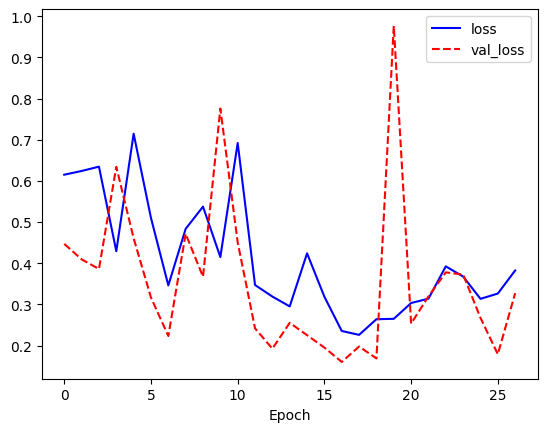

In [41]:
plt.plot(history.history['loss'][5:], 'b-', label='loss')
plt.plot(history.history['val_loss'][5:], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

9/9 [==============================] - 1s 80ms/step


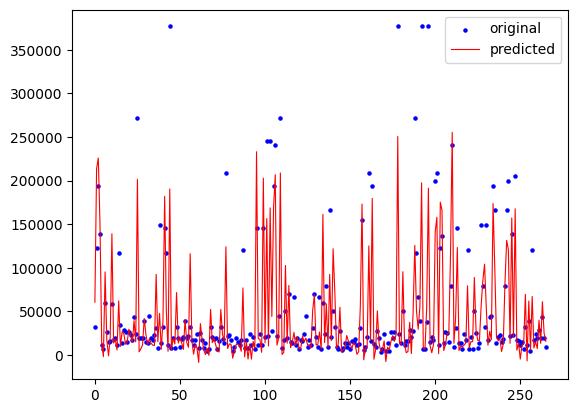

In [42]:
pred = cnn_model.predict(test_x)
inv_test_y = standard_scaler_y.inverse_transform(test_y)
inv_pred = standard_scaler_y.inverse_transform(pred)

x_ax = range(len(inv_pred))
plt.scatter(x_ax, inv_test_y, s=5, color="blue", label="original")
plt.plot(x_ax, inv_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [45]:
print("RMSE: %.4f" % mean_squared_error(inv_test_y, inv_pred)**(1/2))

RMSE: 36455.4700
